In [1]:
"""
Topic: Model Agnostic Meta Learning
Paper Link : https://arxiv.org/abs/1703.03400

This notebook contains an initial implementation of MAML along with some data visualisation
"""

'\nTopic: Model Agnostic Meta Learning\nPaper Link : https://arxiv.org/abs/1703.03400\n\nThis notebook contains an initial implementation of MAML along with some data visualisation\n'

In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

In [4]:
#Open source specific imports
import os 
import json
import matplotlib.pyplot as plt
import random
import numpy as np
import pandas as pd
import torch
import torchvision
import torchvision.models as models
import wandb
import datetime

from pathlib import Path
from typing import *
from PIL import Image
from torchvision import transforms
from torch.utils.data import DataLoader
from types import SimpleNamespace

#Local code specific imports
from utils import *
from configs import *
from dataset.datasets import MiniImageNetDataset
from engine.trainer import do_train
from engine.optimizers import AdamExplicitGrad

/anaconda/envs/maml_pyt/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
#Read config dictionary for this experiment

config = ExperimentConfig()
if config.curr_run is None:
    config.curr_run = str(datetime.datetime.now())



In [6]:
if config.training.wandb_logging:
    wandb.init(
        project="maml++",
        name=f"experiment_{config.curr_run}",
        config=config)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: sahuamrit. Use `wandb login --relogin` to force relogin


In [7]:
#Setting seeds for reproducability
torch.manual_seed(config.seed)
np.random.seed(config.seed)
random.seed(config.seed)

In [8]:
#Global Variables
os.environ['TORCH_HOME'] = config.model.torch_home

#Imagenet mean and var to normalise the input images
ImageNetMean, ImageNetVariance = ((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))

#Human readable class mapping of ImageNet classes
class_map = pd.read_csv(config.dataset.classmap_path, header = None, delimiter=" ")
class_map = dict(zip(class_map[0],class_map[1]))

In [9]:
train_classes = os.listdir(config.dataset.train_path)
test_classes = os.listdir(config.dataset.test_path)
val_classes = os.listdir(config.dataset.val_path)

print(config)

ExperimentConfig(curr_run='2022-06-18 18:36:42.393193', dataset=namespace(classmap_path='/home/azureuser/cloudfiles/code/Users/asahu.cool/Work/HowToTrainYourMAMLPytorch/dataset/classmap.csv', root_path='/home/azureuser/cloudfiles/code/Users/asahu.cool/Work/Datasets/MiniImageNet/mini_imagenet_full_size', sample_train=0.1, sample_val=0.1, test_path='/home/azureuser/cloudfiles/code/Users/asahu.cool/Work/Datasets/MiniImageNet/mini_imagenet_full_size/test', train_path='/home/azureuser/cloudfiles/code/Users/asahu.cool/Work/Datasets/MiniImageNet/mini_imagenet_full_size/train', val_path='/home/azureuser/cloudfiles/code/Users/asahu.cool/Work/Datasets/MiniImageNet/mini_imagenet_full_size/val'), log_dir='/home/azureuser/cloudfiles/code/Users/asahu.cool/Work/HowToTrainYourMAMLPytorch/runs', model=namespace(torch_home='/home/azureuser/cloudfiles/code/Users/asahu.cool/Work/Models'), seed=0, training=namespace(K_shot=5, N_way=5, batch_size=4, gpu=True, image_size=(128, 128), inner_loop_steps=5, inner

Text(0, 0.5, 'No of Images')

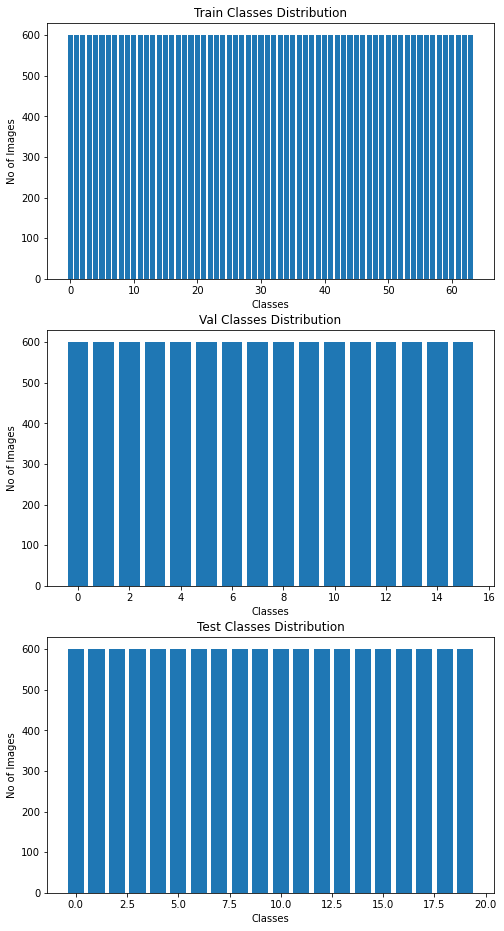

In [10]:
#Plotting Data Distributions for Train, Test and Val

train_class_distrib = class_distribution(config.dataset.train_path,train_classes)
val_class_distrib = class_distribution(config.dataset.val_path,val_classes)
test_class_distrib = class_distribution(config.dataset.test_path,test_classes)

fig = plt.figure(figsize=(8,16))

fig.add_subplot(3,1,1)
plt.bar(list(range(len(train_class_distrib.keys()))), train_class_distrib.values())
plt.title("Train Classes Distribution")
plt.xlabel("Classes")
plt.ylabel("No of Images")


fig.add_subplot(3,1,2)
plt.bar(list(range(len(val_class_distrib.keys()))), val_class_distrib.values())
plt.title("Val Classes Distribution")
plt.xlabel("Classes")
plt.ylabel("No of Images")

fig.add_subplot(3,1,3)
plt.bar(list(range(len(test_class_distrib.keys()))), test_class_distrib.values())
plt.title("Test Classes Distribution")
plt.xlabel("Classes")
plt.ylabel("No of Images")


In [11]:
train_imgs = sample_imgs(config.dataset.train_path,train_classes,0.1,2)

Image of class type: slot


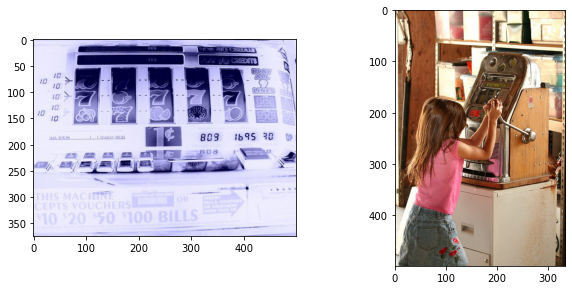

In [12]:
print(f"Image of class type: {class_map[list(train_imgs.keys())[0]]}")
plot_images_grid(3,3,list(train_imgs.values())[0],figsize=(16,16))

Image of class type: spider_web


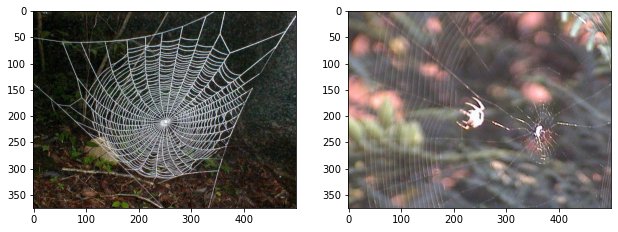

In [13]:
print(f"Image of class type: {class_map[list(train_imgs.keys())[1]]}")
plot_images_grid(3,3,list(train_imgs.values())[1],figsize=(16,16))

In [14]:
transform = torch.nn.Sequential(
    transforms.Resize(config.training.image_size),
    transforms.Normalize(ImageNetMean,ImageNetVariance)
)

In [15]:
# TODO Dataset Reproducability incase training interupts
mini_imagenet_dataset_train = MiniImageNetDataset(config.dataset.train_path,\
    N_way=config.training.N_way,\
        K_shot=config.training.K_shot,\
            query_samples_per_class=config.training.query_samples_per_class, \
                transform= transform, sample_frac = config.dataset.sample_train)

mini_imagenet_dataset_val = MiniImageNetDataset(config.dataset.val_path,\
    N_way=config.training.N_way,\
        K_shot=config.training.K_shot,\
            query_samples_per_class=config.training.query_samples_per_class, \
                transform= transform, sample_frac = config.dataset.sample_val )

No of classes in /home/azureuser/cloudfiles/code/Users/asahu.cool/Work/Datasets/MiniImageNet/mini_imagenet_full_size/train are 64
No of classes in /home/azureuser/cloudfiles/code/Users/asahu.cool/Work/Datasets/MiniImageNet/mini_imagenet_full_size/val are 16


In [16]:
train_dl = DataLoader(mini_imagenet_dataset_train,batch_size= config.training.batch_size,shuffle= True)
val_dl = DataLoader(mini_imagenet_dataset_val,batch_size= config.training.batch_size,shuffle= False)

In [17]:
resnet18 = models.resnet18(pretrained=True)
resnet18.fc = torch.nn.Linear(512,config.training.N_way)

In [18]:
device = 'cpu'
if config.training.gpu:
    if torch.cuda.is_available():
        device = f"cuda:{torch.cuda.current_device()}"
      
resnet18.to(device)
optim = torch.optim.Adam(resnet18.parameters(), lr = config.training.lr)
optim.defaults['inner_lr'] = config.training.inner_lr
#TODO Implement cosine annealing
#TODO Implement ckpting
#TODO Implement a trainer class to store info like iterations epochs etc

iteration = 0

for epoch in range(config.training.n_epochs):
        
    do_train(iteration , epoch , device,torch.nn.BCEWithLogitsLoss(),optim,AdamExplicitGrad,\
        resnet18, train_dl, val_dl, config)
    


/anaconda/envs/maml_pyt/lib/python3.7/site-packages/torch/_tensor.py:1104: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755953518/work/build/aten/src/ATen/core/TensorBody.h:475.)
  return self._grad


Training: Epoch: 0 Iteration: 1 Loss => 0.3685 with batch size => 4
Training: Epoch: 0 Iteration: 1 Accuracy => 72.50% with total_preds => 40 
Training: Epoch: 0 Iteration: 2 Loss => 0.7142 with batch size => 4
Training: Epoch: 0 Iteration: 2 Accuracy => 30.00% with total_preds => 40 
Validation: Epoch: 0 Iteration: 2 Loss => 0.6326 with batch size => 3
Validation: Epoch: 0 Iteration: 2 Accuracy => 32.96% with total_preds => 270 
Training: Epoch: 0 Iteration: 3 Loss => 0.5662 with batch size => 4
Training: Epoch: 0 Iteration: 3 Accuracy => 27.50% with total_preds => 40 
Training: Epoch: 0 Iteration: 4 Loss => 0.5181 with batch size => 4
Training: Epoch: 0 Iteration: 4 Accuracy => 37.50% with total_preds => 40 
Validation: Epoch: 0 Iteration: 4 Loss => 0.5890 with batch size => 3
Validation: Epoch: 0 Iteration: 4 Accuracy => 27.78% with total_preds => 270 
Training: Epoch: 0 Iteration: 5 Loss => 0.5143 with batch size => 4
Training: Epoch: 0 Iteration: 5 Accuracy => 37.50% with total_pr

In [19]:
if config.training.wandb_logging:
    wandb.finish()

trainingQuerySetAccuracyPerMinibatch,█▃▃▄▄▂▁▂▃▃▄▂▂▃▃▂▁▃▂▁▂▃▂▂▃▃▂▂
trainingQuerySetLossPerMinibatch,▁█▅▄▄▅▅▄▄▅▃▄▃▄▃▄▅▅▄▅▆▄▄▄▄▄▅▅
valAccuracy,█▅▄▆▃▂▂▃▄▁▂▃▃▃
valLoss,█▆▃▁▁▂▂▁▂▄▃▂▂▂
trainingQuerySetAccuracyPerMinibatch,20.0
trainingQuerySetLossPerMinibatch,0.58855
valAccuracy,25.55556
valLoss,0.51799


In [20]:
import gc
gc.collect()
torch.cuda.empty_cache()
(xs,ys), (xq,yq) = next(iter(val_dl)) 
batch_sz, support_sz, C, H, W = xs.shape
outp = resnet18(xs.reshape(-1,C,H,W).cuda())
outp.device, outp.shape

(device(type='cuda', index=0), torch.Size([100, 5]))

In [21]:
_ , y_preds = torch.max(outp,dim=1)

In [22]:
y_preds[:25]

tensor([4, 2, 4, 4, 4, 4, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 3,
        2], device='cuda:0')